In [1]:
import pandas as pd
import numpy as np
import random
#import featuretools as ft
import os
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import seaborn as sns
#from featuretools.primitives import Weekend
%matplotlib inline
import os
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from sklearn import preprocessing

Using TensorFlow backend.


In [31]:
df = pd.read_csv('03_Project/Data/train.csv.gz')
df_test = pd.read_csv('03_Project/Data/test.csv.gz')

# EDA & Preprocessing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63771751 entries, 0 to 63771750
Data columns (total 11 columns):
week_number               int64
sales_depot_id            int64
sales_channel_id          int64
route_id                  int64
client_id                 int64
product_id                int64
sales_unit_this_week      int64
sales_this_week           float64
returns_unit_next_week    int64
returns_next_week         float64
adjusted_demand           int64
dtypes: float64(2), int64(9)
memory usage: 5.2 GB


In [4]:
df.describe()

,week_number,sales_depot_id,sales_channel_id,route_id,client_id,product_id,sales_unit_this_week,sales_this_week,returns_unit_next_week,returns_next_week,adjusted_demand
count,6.377175e+07,6.377175e+07,6.377175e+07,6.377175e+07,6.377175e+07,6.377175e+07,6.377175e+07,6.377175e+07,6.377175e+07,6.377175e+07,6.377175e+07
mean,5.452209e+00,2.544955e+03,1.379839e+00,2.113600e+03,1.800568e+06,2.074336e+04,7.311695e+00,6.850541e+01,1.257799e-01,1.238281e+00,7.226821e+00
std,1.717045e+00,4.096279e+03,1.453909e+00,1.486920e+03,2.300695e+06,1.864917e+04,2.194762e+01,3.399487e+02,4.307584e+00,3.995596e+01,2.174982e+01
min,3.000000e+00,1.110000e+03,1.000000e+00,1.000000e+00,2.600000e+01,4.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+00,1.312000e+03,1.000000e+00,1.161000e+03,3.569810e+05,1.242000e+03,2.000000e+00,1.676000e+01,0.000000e+00,0.000000e+00,2.000000e+00
50%,5.000000e+00,1.613000e+03,1.000000e+00,1.285000e+03,1.192709e+06,3.053200e+04,3.000000e+00,3.000000e+01,0.000000e+00,0.000000e+00,3.000000e+00
75%,7.000000e+00,2.036000e+03,1.000000e+00,2.802000e+03,2.368773e+06,3.736100e+04,7.000000e+00,5.610000e+01,0.000000e+00,0.000000e+00,6.000000e+00
max,8.000000e+00,2.575900e+04,1.100000e+01,9.991000e+03,2.015152e+09,4.999700e+04,7.200000e+03,6.473600e+05,1.634500e+04,1.307600e+05,5.000000e+03


In [3]:
df.head()

,week_number,sales_depot_id,sales_channel_id,route_id,client_id,product_id,sales_unit_this_week,sales_this_week,returns_unit_next_week,returns_next_week,adjusted_demand
0,3,1110,7,3301,15766,1212,3,25.14,0,0.0,3
1,3,1110,7,3301,15766,1216,4,33.52,0,0.0,4
2,3,1110,7,3301,15766,1238,4,39.32,0,0.0,4
3,3,1110,7,3301,15766,1240,4,33.52,0,0.0,4
4,3,1110,7,3301,15766,1242,3,22.92,0,0.0,3


In [6]:
df.isnull().values.any()

False

## Sales Channel Analysis

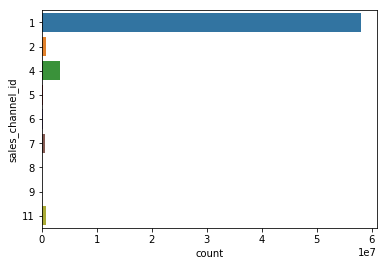

In [7]:
from seaborn import countplot
from matplotlib.pyplot import figure, show

figure()
countplot(data=df,y=df.sales_channel_id)
show()

#Sales Channel 1 hat mit Abstand die meisten Werte

## Analyse & Bereinigung sales unit this week

In [8]:
df["sales_unit_this_week"].mean()

7.3116953931529967

In [9]:
df["sales_unit_this_week"].median()

3.0

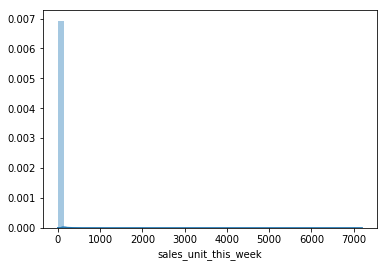

In [4]:
sns.distplot(df.sales_unit_this_week)

So wie es aussieht, sind die Daten right skewed aufgrund hoher Ausreißer -> Diese werden aus dem Datensatz entfernt

In [5]:
Q_98 = df['sales_unit_this_week'].quantile(q=0.98)
np.int64(Q_98)
#Als int64 speichern
print(Q_98)

40.0


In [6]:
df = df[(df.sales_unit_this_week <= Q_98)]
#Filtern auf das 98% Quantil

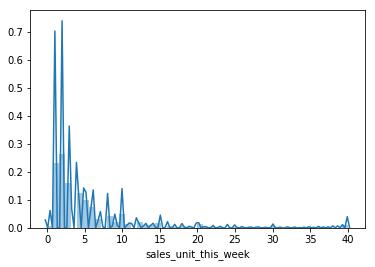

In [7]:
sns.distplot(df.sales_unit_this_week)
#Diese Verteilung sieht gleich viel besser aus

## Analyse & Bereinigung sales this week

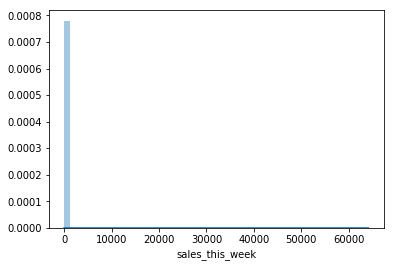

In [8]:
sns.distplot(df.sales_this_week)
#Die Umsatzverteilung ist immernoch ziemlich auseinandergezogen

In [9]:
df.quantile(q=0.99)
#Hier zeigt sich, dass nicht alle Umsatzausreißer entfernt wurden

week_number                     8.00
sales_depot_id              23899.00
sales_channel_id               11.00
route_id                     6629.00
client_id                 8111012.00
product_id                  48417.00
sales_unit_this_week           36.00
sales_this_week               320.85
returns_unit_next_week          2.00
returns_next_week              22.50
adjusted_demand                36.00
Name: 0.99, dtype: float64

In [10]:
Q_98 = df['sales_this_week'].quantile(q=0.99)
np.int64(Q_98)
#Als int64 speichern
print(Q_98)

320.85


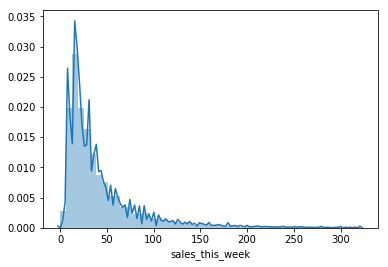

In [11]:
df = df[(df.sales_this_week <= Q_98)]
#Filtern auf das 99% Quantil beim Umsatz
sns.distplot(df.sales_this_week)
#Jetzt sieht auch die Umsatzverteilung plausibel aus

## Analyse & Bereinigung returns unit next week

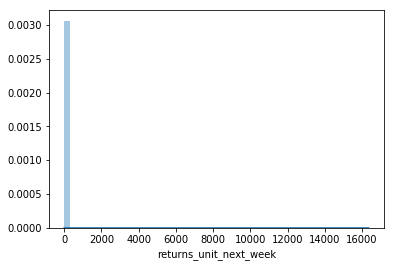

In [12]:
sns.distplot(df.returns_unit_next_week)
#Die Returns sehen auch sehr verzerrt aus

In [13]:
max(df.returns_unit_next_week)
#Scheint enorm hoch zu sein in der Hinsicht, dass das 98% Quantil bei 2 liegt

16345

In [14]:
Q_98 = df['returns_unit_next_week'].quantile(q=0.999)
np.int64(Q_98)
#Als int64 speichern
print(Q_98)
#Da das 99,9% Quantil bei 12 liegt handelt es sich bei dem Maximum Wert wahrscheinlich um ein seltsamen Ausreißer

12.0


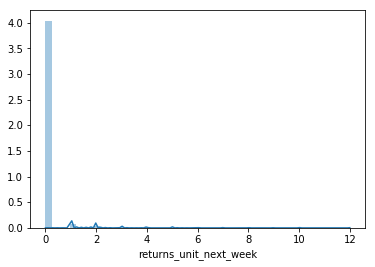

In [15]:
df = df[(df.returns_unit_next_week <= Q_98)]
sns.distplot(df.returns_unit_next_week)
#Die meisten Werte liegen um 0 aber bei Return von 12 ist nicht unrealistisch

## Analyse & Bereinigung returns next week

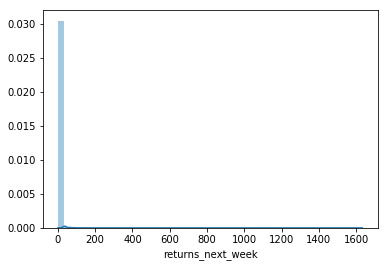

In [16]:
sns.distplot(df.returns_next_week)
#Hier genau das gleiche Problem wieder

In [17]:
Q_98 = df['returns_next_week'].quantile(q=0.999)
np.int64(Q_98)
#Als int64 speichern
print(Q_98)
#Da das 99,9% Quantil bei 12 liegt handelt es sich bei dem Maximum Wert wahrscheinlich um ein seltsamen Ausreißer

76.4


In [18]:
df = df[(df.returns_next_week <= Q_98)]

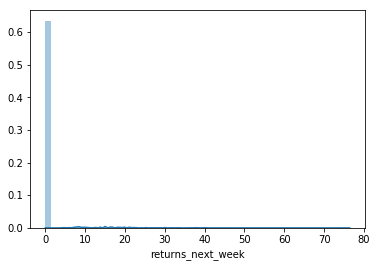

In [19]:
sns.distplot(df.returns_next_week)

Conclusion: Dataframe sollte jetzt von den groben Ausreißern bereinigt sein

## Monatliche Verkaufszahlen im Zeitverlauf

In [20]:
#Durchschnittswerte bilden auf unterschiedliche Hierarchieebenen
gp_month_mean = df.groupby(['week_number'], as_index=False)['sales_unit_this_week'].mean()
gp_month_sum = df.groupby(['week_number'], as_index=False)['sales_unit_this_week'].sum()
gp_month_count = df.groupby(['week_number'], as_index=False)['sales_unit_this_week'].count()

gp_category_mean = df.groupby(['product_id'], as_index=False)['sales_unit_this_week'].mean()
gp_category_sum = df.groupby(['product_id'], as_index=False)['sales_unit_this_week'].sum()

gp_shop_mean = df.groupby(['sales_channel_id'], as_index=False)['sales_unit_this_week'].mean()
gp_shop_sum = df.groupby(['sales_channel_id'], as_index=False)['sales_unit_this_week'].sum()

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

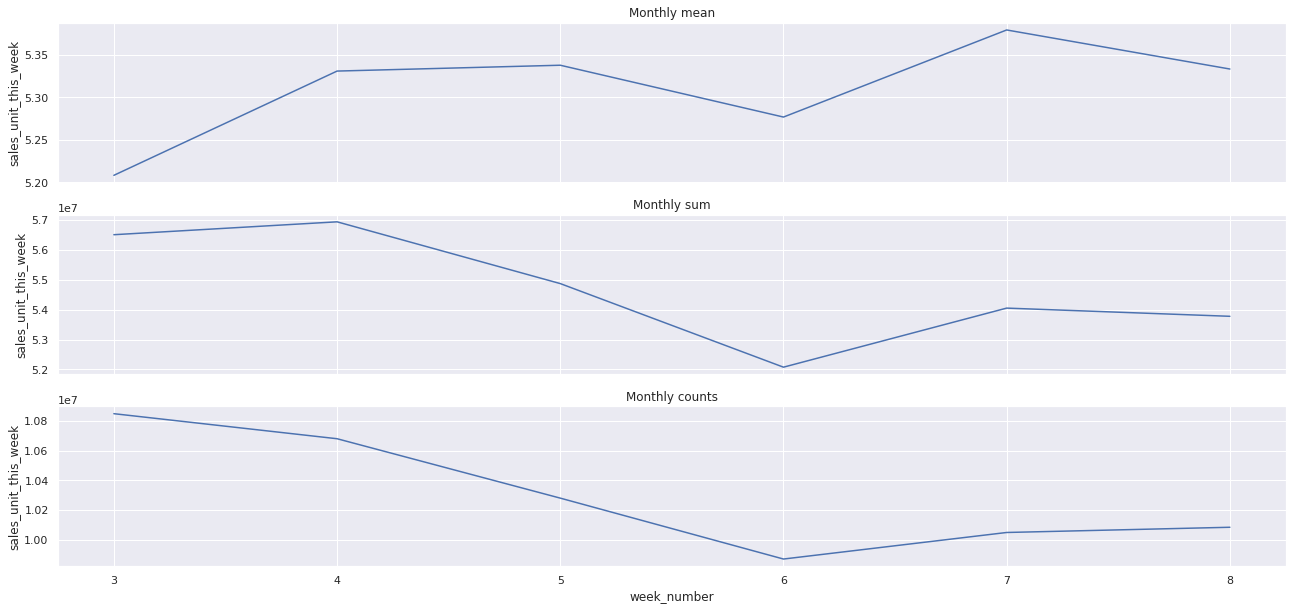

In [22]:
f, axes = plt.subplots(3, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="week_number", y="sales_unit_this_week", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="week_number", y="sales_unit_this_week", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
sns.lineplot(x="week_number", y="sales_unit_this_week", data=gp_month_count, ax=axes[2]).set_title("Monthly counts")
plt.show()

Conclusion: in Woche 6 ist die Gesamtverkaufszahl niedriger, aber der Durchschnitt bleibt stabil.

## Verkaufszahlen nach den einzelnen Produkten

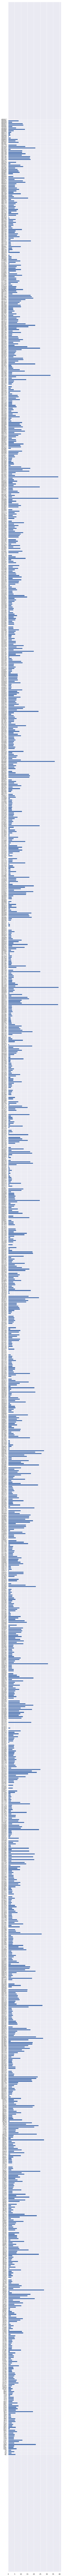

In [23]:
y_pos = np.arange(len(gp_category_mean['product_id']))
fig = plt.figure(figsize=(6,300))
plt.barh(y_pos, gp_category_mean['sales_unit_this_week'])
plt.yticks(y_pos, gp_category_mean['product_id'])
plt.show()


Conclusion: Produkt 45143, 44102, 36692, 33610 sind die absatzstärksten Produkte

## Verkaufszahlen nach Sales Channel

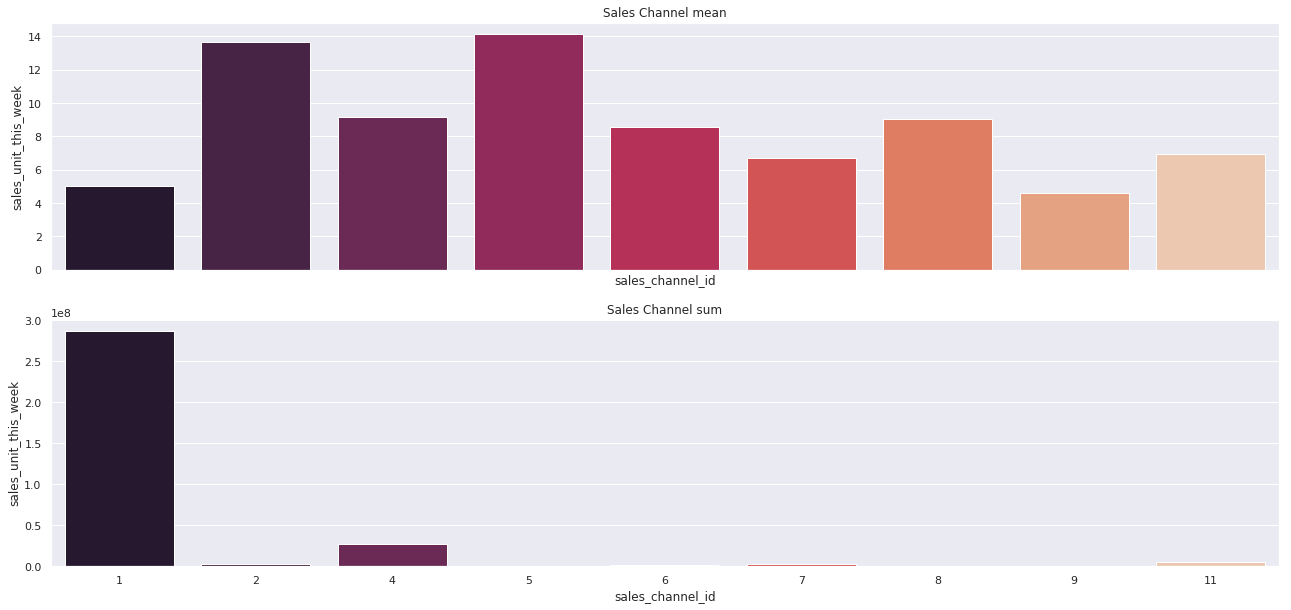

In [24]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="sales_channel_id", y="sales_unit_this_week", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Sales Channel mean")
sns.barplot(x="sales_channel_id", y="sales_unit_this_week", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Sales Channel sum")
plt.show()

Conclusion: Insgesamt wird in Sales Channel 1 am meisten in Summe verkauft. Im Durchschnitt aber werden in den anderen Sales Channel mehr verkauft pro Einheit.

## Verkaufszahlen nach Sales Channel im Zeitverlauf

In [25]:
gp_time_mean = df.groupby(['week_number','sales_channel_id'], as_index=False)['sales_unit_this_week'].mean()
gp_time_sum = df.groupby(['week_number','sales_channel_id'], as_index=False)['sales_unit_this_week'].sum()

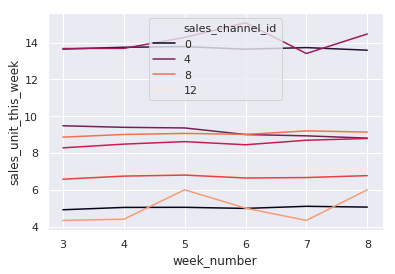

In [26]:
#Entwicklung der durchschnittlichen Verkaufszahlen nach Sales Channel
sns.lineplot(x="week_number", y="sales_unit_this_week", hue="sales_channel_id",
                   palette="rocket", data=gp_time_mean)

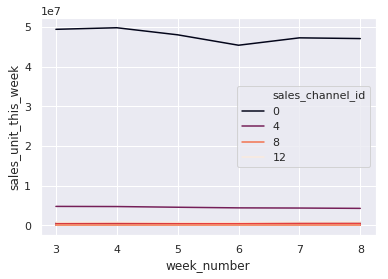

In [27]:
#Entwicklung der summierten Verkaufszahlen nach Sales Channel
sns.lineplot(x="week_number", y="sales_unit_this_week", hue="sales_channel_id",
                   palette="rocket", data=gp_time_sum)

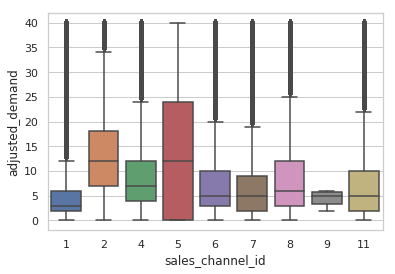

In [28]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="sales_channel_id", y="adjusted_demand", data=df)

Conclusion: Sales Channel 9 scheint am stabilsten zu sein. In jedem Sales Channel sind Ausreißer erkennbar.
Sales Channel 1 auch recht stabil aber Median recht niedrig -> Einige hohe Ausreißerwerte. Range in Sales Channel 5 am höchsten.

## Korrelationsmatrix der Features

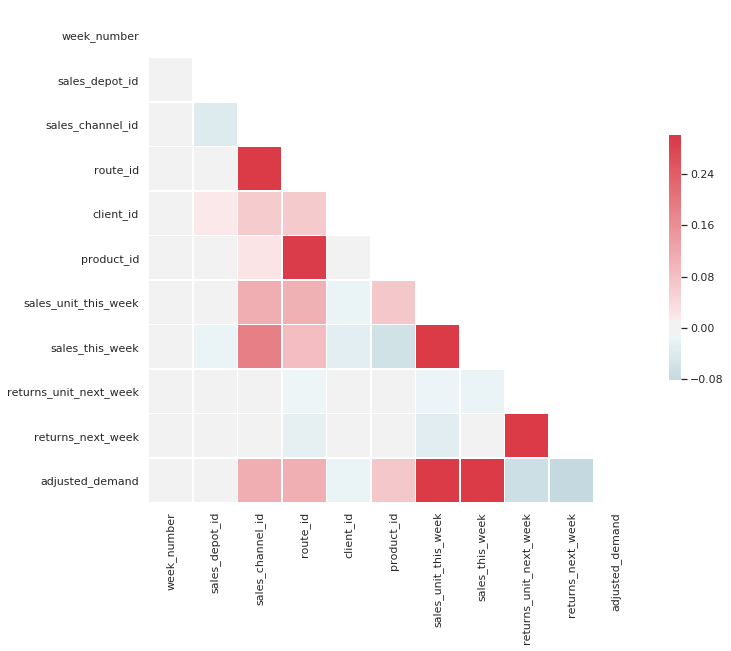

In [29]:
from string import ascii_letters
import matplotlib.pyplot as plt

sns.set(style="white")
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Conclusion: Es ist logisch, dass die Absatz und Umsatzzahlen eine hohe Korrelation aufweisen.
Interessant ist aber zu sehen, dass sowohl die sales_channel_id, die route_id und die product_id mit der Targetvariable korrelieren. Demnach sind sie wichtige Features.

## Adjusted Demand Verteilung

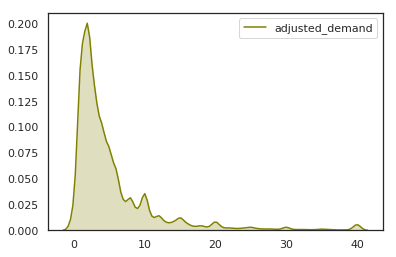

In [30]:
sns.kdeplot(df['adjusted_demand'], shade=True, bw=.5, color="olive")

Conclusion: Die meisten Werte der Targetvariable liegen unter 10 und nur wenige darüber.

# Feature Engineering

## Client-ID

In [32]:
df_customer = pd.read_csv('df_client_NewID.csv')
#CSV mit den ID's laden

In [33]:
df_customer.drop_duplicates(subset='ID', keep='first', inplace=True)
#Duplikate entfernen damit es keine Probleme beim joinen gibt

In [34]:
df = df.merge(df_customer.iloc[:,[1,3]] ,how="left", left_on="client_id", right_on="ID")
#Hinzufügen der new client ID für den Trainingsdatensatz

In [35]:
df_test = df_test.merge(df_customer.iloc[:,[1,3]] ,how="left", left_on="client_id", right_on="ID")
#Hinzufügen der new client ID für den Testdatensatz

## Product-ID

In [36]:
products = pd.read_pickle("df_products_merged.pkl")
products = products.iloc[:,[0,9]]
products= products.rename(index=str, columns={"ID": "ProductID", "cluster": "WRG"})
#CSV mit den Product ID's laden

In [37]:
products.drop_duplicates(subset='ProductID', keep='first', inplace=True)
#Duplikate entfernen damit es keine Probleme beim joinen gibt

In [42]:
df = df.merge(products ,how="left", left_on="product_id", right_on="ProductID")
df_test = df_test.merge(products ,how="left", left_on="product_id", right_on="ProductID")
#Hinzufügen der neuen Product-ID

## ABC Analyse
Die ABC-Analyse ist ein betriebswirtschaftliches Analyseverfahren. Sie teilt eine Menge von Objekten in die Klassen A, B und C auf, die nach absteigender Bedeutung geordnet sind. Eine typische ABC-Analyse gibt beispielsweise an, welche Produkte oder Kunden am stärksten am Umsatz eines Unternehmens beteiligt sind (A) und welche am wenigsten (C).

In [38]:
columNames = ['sales_depot_id', 'sales_channel_id', 'route_id','product_id','NewID', 'WRG']

In [44]:
#group add ABC group to all features
for i in columNames:
    col1=str(i)+"_ABCquantileUnit"
    col2=str(i)+"_ABCquantileRevenue"
    df_cumm = pd.DataFrame(df.groupby([str(i)])['sales_unit_this_week',"sales_this_week"].sum())
    df_cumm[str(col1)] =pd.qcut(df_cumm["sales_unit_this_week"],[0, 0.8, 0.95, 1], labels=False)
    df_cumm[str(col2)] =pd.qcut(df_cumm["sales_this_week"],[0, 0.8, 0.95, 1], labels=False)
    df= df.merge(df_cumm.iloc[:,[2,3]] ,how="left", on=str(i))
    df_test =df_test.merge(df_cumm.iloc[:,[2,3]] ,how="left", on=str(i))
    print(df.shape,df_test.shape)

(61808140, 27) (10408713, 23)
(61808140, 29) (10408713, 25)
(61808140, 31) (10408713, 27)
(61808140, 33) (10408713, 29)
(61808140, 35) (10408713, 31)
(61808140, 37) (10408713, 33)


In [46]:
#Hier werden die nicht vorhandenen Spalten im Testset mit NA's befüllt und mit dem Trainingsdatensatz zusammengefügt, um Durchschnittswerte zu berechnen.
df_test["adjusted_demand"] = np.nan
df_test["sales_unit_this_week "] = np.nan
df_test["sales_this_week"] = np.nan
df_test["returns_unit_next_week"] = np.nan
df_test["returns_next_week"] = np.nan

df = df.append(df_test, sort=True)

## Rolling Mean & Sales unit Vorwoche auf Produktebene
Hier werden insgesamt 3 Features gebaut. Zuerst werden die Daten gruppiert Nach Produkt und Woche. Anschließend wird dann der Durchschnitt der letzten 2 Wochen und der letzten 3 Wochen berechnet. Zusätzlich wird für die aktuelle Woche die Verkaufszahl der vorherigen Woche hinzugefügt.
Hypothese: Verkaufszahlen in Woche X werden maßgeblich von den Verkaufszahlen der letzten Wochen beeinflusst.

In [48]:
df_produkt = df.groupby(['week_number','product_id'], as_index=False)['sales_unit_this_week'].sum()
df_produkt = df_produkt.sort_values(['product_id', 'week_number'], ascending=[True, True])

df_produkt['rolling_mean_2_P'] = df_produkt["sales_unit_this_week"].groupby(df_produkt["product_id"]).shift(1).rolling(2).mean()
df_produkt['rolling_mean_3_P'] = df_produkt["sales_unit_this_week"].groupby(df_produkt["product_id"]).shift(1).rolling(3).mean()
df_produkt['sales_unit_vorwoche_P']  = df_produkt.groupby(df_produkt["product_id"])['sales_unit_this_week'].shift()
df_produkt = df_produkt.drop('sales_unit_this_week',1)

df_neu = pd.merge(df, df_produkt,  how='left', left_on=['week_number','product_id'], right_on = ['week_number','product_id'])

In [49]:
df_produkt = 0

## Gesamtdurchschnittswerte auf unterster Hierarchieebene
Auf der untersten Hierarchiestufe wird der Gesamtdurchschnitt über alle Wochen berechnet und hinzugefügt.

In [50]:
df_produkt = df.groupby(['product_id', "sales_depot_id","sales_channel_id", "route_id", "client_id"], as_index=False)['sales_unit_this_week'].mean()

df_produkt['avg_sales_unit'] = df_produkt['sales_unit_this_week']
df_produkt = df_produkt.drop('sales_unit_this_week',1)

df_neu = pd.merge(df_neu, df_produkt,  how='left', left_on=['product_id', "sales_depot_id","sales_channel_id", "route_id", "client_id"], right_on = ['product_id', "sales_depot_id","sales_channel_id", "route_id", "client_id"])

In [51]:
df_produkt = 0

## Rolling Mean & Adjusted Demand Vorwoche auf Produktebene
Gleiche Logik wie oben allerdings mit dem adjusted demand

In [52]:
df_produkt = df.groupby(['week_number','product_id'], as_index=False)['adjusted_demand'].sum()
df_produkt = df_produkt.sort_values(['product_id', 'week_number'], ascending=[True, True])

df_produkt['rolling_mean_2_P_ad'] = df_produkt["adjusted_demand"].groupby(df_produkt["product_id"]).shift(1).rolling(2).mean()
df_produkt['rolling_mean_3_P_ad'] = df_produkt["adjusted_demand"].groupby(df_produkt["product_id"]).shift(1).rolling(3).mean()
df_produkt['sales_unit_vorwoche_P_ad']  = df_produkt.groupby(df_produkt["product_id"])['adjusted_demand'].shift()
df_produkt = df_produkt.drop('adjusted_demand',1)

df_neu = pd.merge(df_neu, df_produkt,  how='left', left_on=['week_number','product_id'], right_on = ['week_number','product_id'])

In [53]:
test_set = df_neu[(df_neu.week_number == 9)]
#Jetzt wird das Testset wieder gesplittet

In [54]:
test_set = test_set.drop('sales_unit_this_week',1)
test_set = test_set.drop('sales_this_week',1)
test_set = test_set.drop('returns_unit_next_week',1)
test_set = test_set.drop('returns_next_week',1)
test_set = test_set.drop('adjusted_demand',1)
#Die NA Spalten wieder droppen

In [ ]:
#test_set.to_csv("test_final.csv")
#Testset speichern -> Wird nur einmal ausgeführt, damit die vorherigen Schritte nicht nochmal ausgeführt werden müssen für die Modellierung

In [55]:
df_neu = df_neu[(df_neu.week_number < 9)]
df_neu = df_neu.drop('sales_unit_this_week',1)
df_neu = df_neu.drop('sales_this_week',1)
df_neu = df_neu.drop('returns_unit_next_week',1)
df_neu = df_neu.drop('returns_next_week',1)
df_neu = df_neu.drop('sales_unit_this_week ',1)

In [ ]:
#df_neu.to_csv("train_final.csv")
#Trainingsset speichern -> Wird nur einmal ausgeführt, damit die vorherigen Schritte nicht nochmal ausgeführt werden müssen für die Modellierung

## Korrelationsmatrix nach dem Feature Engineering

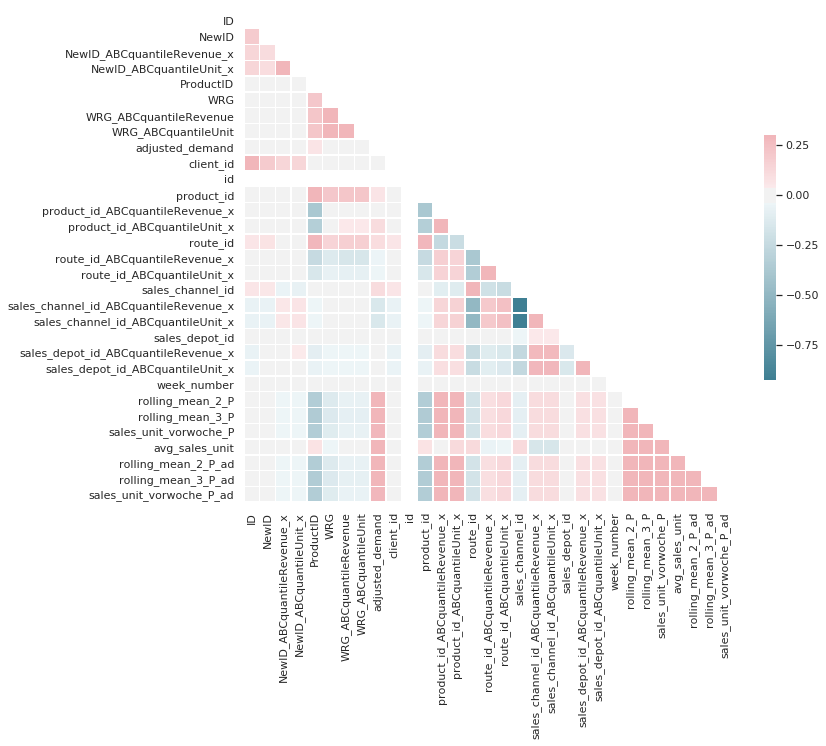

In [68]:
from string import ascii_letters
import matplotlib.pyplot as plt

sns.set(style="white")
corr = df_neu.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Conclusion: Es ist deutlich zu sehen, dass die neuen Features die höchste Korrelation mit dem adjusted demand haben

# Modeling

In [2]:
train = pd.read_csv('train_final.csv')
test = pd.read_csv('test_final.csv')
#Daten wieder reinladen -> ursprünglich waren das zwei verschiedene Skripte, da unser RAM vollgelaufen ist wenn wir es in einem Notebook haben

In [4]:
print(train.isna().values.any())
print(test.isna().values.any())

False
False


In [3]:
test.fillna(test.mean(),inplace=True)
train.fillna(train.mean(),inplace=True)
#Bei NA's werden die NA's mit dem Spaltendurchschnitt ersetzt -> Besonders wichtig bei den Rolling Means

In [4]:
train = train.drop(train.columns[0], axis=1)
train = train.drop(train.columns[0], axis=1)
#Die doppelten Spalten löschen

In [5]:
test = test.drop(test.columns[0], axis=1)
test = test.drop(test.columns[0], axis=1)
#Die doppelten Spalten löschen

In [5]:
train.head()

,NewID,NewID_ABCquantileRevenue,NewID_ABCquantileUnit,ProductID,WRG,WRG_ABCquantileRevenue,WRG_ABCquantileUnit,adjusted_demand,client_id,product_id,...,sales_depot_id_ABCquantileRevenue,sales_depot_id_ABCquantileUnit,week_number,rolling_mean_2_P,rolling_mean_3_P,sales_unit_vorwoche_P,avg_sales_unit,rolling_mean_2_P_ad,rolling_mean_3_P_ad,sales_unit_vorwoche_P_ad
0,254004,0.0,0.0,1212,5,2,2,3.0,15766,1212,...,0.0,0.0,3,612352.243347,610290.137833,616254.151217,4.000000,607442.840727,605321.400788,611384.146392
1,254004,0.0,0.0,1216,5,2,2,4.0,15766,1216,...,0.0,0.0,3,612352.243347,610290.137833,616254.151217,2.833333,607442.840727,605321.400788,611384.146392
2,254004,0.0,0.0,1238,1,0,0,4.0,15766,1238,...,0.0,0.0,3,612352.243347,610290.137833,616254.151217,2.500000,607442.840727,605321.400788,611384.146392
3,254004,0.0,0.0,1240,5,2,2,4.0,15766,1240,...,0.0,0.0,3,612352.243347,610290.137833,616254.151217,5.250000,607442.840727,605321.400788,611384.146392
4,254004,0.0,0.0,1242,1,0,0,3.0,15766,1242,...,0.0,0.0,3,612352.243347,610290.137833,616254.151217,2.333333,607442.840727,605321.400788,611384.146392


In [17]:
test.head()

,NewID,NewID_ABCquantileRevenue,NewID_ABCquantileUnit,ProductID,WRG,WRG_ABCquantileRevenue,WRG_ABCquantileUnit,client_id,product_id,product_id_ABCquantileRevenue,...,sales_depot_id_ABCquantileRevenue,sales_depot_id_ABCquantileUnit,week_number,rolling_mean_2_P,rolling_mean_3_P,sales_unit_vorwoche_P,avg_sales_unit,rolling_mean_2_P_ad,rolling_mean_3_P_ad,sales_unit_vorwoche_P_ad
0,254004,0.0,0.0,1212,5,2,2,15766,1212,2.0,...,0.0,0.0,9,450409.0,4.557753e+05,440460.0,4.000000,440073.0,4.455647e+05,429900.0
1,254004,0.0,0.0,1238,1,0,0,15766,1238,2.0,...,0.0,0.0,9,488471.0,4.974517e+05,475246.0,2.500000,477690.0,4.869127e+05,463917.0
2,254004,0.0,0.0,1240,5,2,2,15766,1240,2.0,...,0.0,0.0,9,1514683.0,1.526318e+06,1481915.0,5.250000,1500927.5,1.512954e+06,1468223.0
3,254004,0.0,0.0,1242,1,0,0,15766,1242,2.0,...,0.0,0.0,9,1404696.0,1.420106e+06,1356166.0,2.333333,1393194.0,1.408843e+06,1344337.0
4,254004,0.0,0.0,1250,2,0,0,15766,1250,2.0,...,0.0,0.0,9,1465555.5,1.459309e+06,1443252.0,6.500000,1450872.5,1.444944e+06,1428338.0


In [6]:
#Splitten in Target Vektor und droppen im Trainingsdatensatz
target = train['adjusted_demand']
train.drop('adjusted_demand', axis = 1, inplace = True)

In [7]:
train_X, val_X, train_y, val_y = train_test_split(train, target, test_size = 0.25, random_state = 14)
#Trainingsdatensatz wird unterteilt in Validierungsset und Trainingsset

## Random Forest

In [10]:
model = RandomForestRegressor(n_estimators = 20, n_jobs=-1, random_state = 201)
model.fit(train_X,train_y)

predicted_demand = model.predict(val_X)
MAE = mean_absolute_error(val_y , predicted_demand)
print('Random forest validation MAE = ', MAE)

Random forest validation MAE =  1.49173981291


In [20]:
predictions_RF = model.predict(train)

In [21]:
prediction = pd.DataFrame(predictions_RF, columns=['predictions']).to_csv('prediction_rf_train.csv')
#Da Modell zu groß ist werden nur die Predictions gespeichert, um diese später für das second stage Model zu benutzen

## XGBoost

In [22]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, random_state =11102, nthread=-1)
xgb_model.fit(train_X, train_y, early_stopping_rounds=3, 
             eval_set=[(val_X, val_y)], verbose=False)

[19:36:01] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=-1, objective='reg:linear', random_state=11102,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [30]:
predictions_xgb = xgb_model.predict(train)

In [29]:
model = 0
test = 0
predictions_RF = 0
train_X = 0
val_X = 0
train_y = 0
val_y = 0

del model
del test
del predictions_RF
del train_X
del val_X
del train_y
del val_y

#Um wieder Arbeitsspeicher freizusetzen

In [31]:
prediction = pd.DataFrame(predictions_xgb, columns=['predictions']).to_csv('prediction_xgb_train.csv')

## Neural Net

In [10]:
NN_model = Sequential()

#Input Layer
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

#Hidden Layers
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

#Output Layer
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

#MAE als Optimierungskennzahl
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

#In jedem Durchgang werden die Weights als checkpoint gespeichert
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               3712      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 168,577
Trainable params: 168,577
Non-trainable params: 0
_________________________________________________________________


In [15]:
NN_model.fit(train, target, epochs=50, batch_size=1000, validation_split = 0.25, callbacks=callbacks_list)

Train on 46356105 samples, validate on 15452035 samples
Epoch 1/50
46356105/46356105 [==============================] - 803s 17us/step - loss: 3.5037 - mean_absolute_error: 3.5037 - val_loss: 3.5439 - val_mean_absolute_error: 3.5439

Epoch 00001: val_loss did not improve from 3.54374
Epoch 2/50
46356105/46356105 [==============================] - 800s 17us/step - loss: 3.5037 - mean_absolute_error: 3.5037 - val_loss: 3.5438 - val_mean_absolute_error: 3.5438

Epoch 00002: val_loss did not improve from 3.54374
Epoch 3/50
46356105/46356105 [==============================] - 815s 18us/step - loss: 3.5037 - mean_absolute_error: 3.5037 - val_loss: 3.5443 - val_mean_absolute_error: 3.5443

Epoch 00003: val_loss did not improve from 3.54374
Epoch 4/50
46356105/46356105 [==============================] - 857s 18us/step - loss: 3.5037 - mean_absolute_error: 3.5037 - val_loss: 3.5440 - val_mean_absolute_error: 3.5440

Epoch 00004: val_loss did not improve from 3.54374
Epoch 5/50
46356105/46356105

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



46356105/46356105 [==============================] - 848s 18us/step - loss: 3.5036 - mean_absolute_error: 3.5036 - val_loss: 3.5438 - val_mean_absolute_error: 3.5438

Epoch 00020: val_loss did not improve from 3.54373
Epoch 21/50
46356105/46356105 [==============================] - 864s 19us/step - loss: 3.5036 - mean_absolute_error: 3.5036 - val_loss: 3.5438 - val_mean_absolute_error: 3.5438

Epoch 00021: val_loss did not improve from 3.54373
Epoch 22/50
46356105/46356105 [==============================] - 867s 19us/step - loss: 3.5036 - mean_absolute_error: 3.5036 - val_loss: 3.5439 - val_mean_absolute_error: 3.5439

Epoch 00022: val_loss did not improve from 3.54373
Epoch 23/50
46356105/46356105 [==============================] - 836s 18us/step - loss: 3.5036 - mean_absolute_error: 3.5036 - val_loss: 3.5441 - val_mean_absolute_error: 3.5441

Epoch 00023: val_loss did not improve from 3.54373
Epoch 24/50
46356105/46356105 [==============================] - 853s 18us/step - loss: 3.50

KeyboardInterrupt: 

Model wird trainiert mit 50 Epochs -> Dauert sehr lange

In [17]:
wights_file = 'Weights-016--3.54373.hdf5' #Name der "optimalen" Weights
NN_model.load_weights(wights_file)
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [20]:
predictions_NN = NN_model.predict(train)

In [21]:
prediction = pd.DataFrame(predictions_NN, columns=['predictions']).to_csv('prediction_NN_train.csv')

## LigtGBM
Wurde nicht benutzt aufgrund zu langer Berechnungszeit

In [53]:
import lightgbm as lgb

In [57]:
model_lgb = lgb.LGBMRegressor(objective='regression', learning_rate=0.05, n_estimators=700,
                              bagging_fraction = 0.8, bagging_freq = 5, feature_fraction = 0.2,
                              feature_fraction_seed=9, bagging_seed=9, num_threads = 20)

In [ ]:
model_lgb.fit(train_X,train_y)

predicted_demand = model.predict(val_X)
MAE = mean_absolute_error(val_y , predicted_demand)
print('LightGBM validation MAE = ', MAE)

## K-NN
Wurde nicht benutzt aufgrund zu langer Berechnungszeit

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
modelKNN = KNeighborsRegressor(n_jobs=-1)
predicted_demand = modelKNN.fit(train_X,train_y)
MAE = mean_absolute_error(val_y , predicted_demand)
print('KNN validation MAE = ', MAE)

In [ ]:
predictions_KNN = modelKNN.predict(df)

## 2 Second Stage Model
Die Predictions der vorherigen Modelle werden nun als Feautures für das finale Modell benutzt. Das Neural Net wird an dieser Stelle doch nicht berücksichtigt, da es wesentlich schlechter performed als der Random Forest und der XGBoost

In [25]:
train_rf = pd.read_csv('prediction_rf_train.csv')
train_xgb = pd.read_csv('prediction_xgb_train.csv')
train_nn = pd.read_csv('prediction_NN_train.csv')

test_rf = pd.read_csv('prediction_rf.csv')
test_xgb = pd.read_csv('prediction_xgb.csv')
test_nn = pd.read_csv('prediction_NN.csv')
#Predictions laden

In [42]:
train_rf = train_rf.drop(train_rf.columns[0], axis=1)
train_xgb = train_xgb.drop(train_xgb.columns[0], axis=1)

test_rf = test_rf.drop(test_rf.columns[0], axis=1)
test_xgb = test_xgb.drop(test_xgb.columns[0], axis=1)

In [43]:
train_stacked = np.column_stack((train_rf, train_xgb))

In [44]:
test_stacked = np.column_stack((test_rf, test_xgb))

In [47]:
train_X, val_X, train_y, val_y = train_test_split(train_stacked, target, test_size = 0.25, random_state = 14)
#Erneuter Trainings-Validationsplit

In [48]:
model = RandomForestRegressor(n_estimators = 25, n_jobs=-1, random_state = 202)
model.fit(train_X,train_y)

predicted_demand = model.predict(val_X)
MAE = mean_absolute_error(val_y , predicted_demand)
print('Random forest validation MAE = ', MAE)

Random forest validation MAE =  1.57642136967


In [50]:
predictions_RF = model.predict(test_stacked)

In [52]:
prediction = pd.DataFrame(predictions_RF, columns=['predictions']).to_csv('prediction_stacked.csv')

Conclusion: Second Stage Model performed nicht besser als der Random Forest alleine. Allerdings weniger anfällig für Overfitting.